In [1]:
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import sys
import pickle as pkl
sys.path.append('..')

from process_latent_perceptual_dists import ks
import data
import style
import config
from config import *
import util

## process the latents

In [2]:
# !python process_latent_perceptual_dists.py

In [8]:
# check if first generations are done
for d in os.listdir(DIR_PROCESSED):
    if 'generated_images_' in d:
        num = 0
        for num in range(30000):
            s = f'{num + 1:05d}.npy'
            if not os.path.exists(oj(DIR_PROCESSED, d, s)):
                break
        print(d, 'first', num, 'calculated')
        
    # save out first 300

generated_images_10000 first 300 calculated
generated_images_10 first 62 calculated
generated_images_1 first 1541 calculated
generated_images_0.1 first 8875 calculated
generated_images_0 first 321 calculated
generated_images_0.01 first 354 calculated


In [ ]:
# for the final selected dir, see if we are missing any projections
exists = np.zeros(30000)
for num in range(30000):
    s = f'{num + 1:05d}.npy'
    exists[num] = os.path.exists(oj(DIR_GEN, s))
print(np.sum(exists))

plt.plot(np.arange(30000)[exists == 0])
plt.grid()
print(sorted(os.listdir(DIR_GEN))[-1])

# analyze results after processing the latents

In [ ]:
# !python process_latent_facial_dists

In [45]:
# df = pd.DataFrame([pkl.load(open(oj(DIR_PROCESSED, 'processed_latents', f), 'rb'))
#                    for f in sorted(os.listdir(oj(DIR_PROCESSED, 'processed_latents'))) if 'pkl' in f])
# df.to_csv(oj(DIR_PROCESSED, 'processed_latents_perceptual.csv'))
df = pd.read_csv(oj(DIR_PROCESSED, 'processed_latents_perceptual.csv'))
reg_params = df.reg_param.unique()
n = int(df.shape[0] / reg_params.size)
df['perceptual_sim'] = 1 - df['perceptual_loss']

# add in all the label keys
df_labs = data.load_all_labs()[:n]
for reg_param in reg_params:
    for k in df_labs.keys():
        df.loc[df.reg_param == reg_param, k] = df_labs[k]
        
        
        
# load facial dists        
fname_faceid = oj(DIR_PROCESSED_MISC, f'facial_dists_after_projection.csv')
d = pd.read_csv(fname_faceid)
# d = pd.read_csv(oj(DIR_PROCESSED_MISC, '09_dists_50.csv'))

### perceptual loss preservation

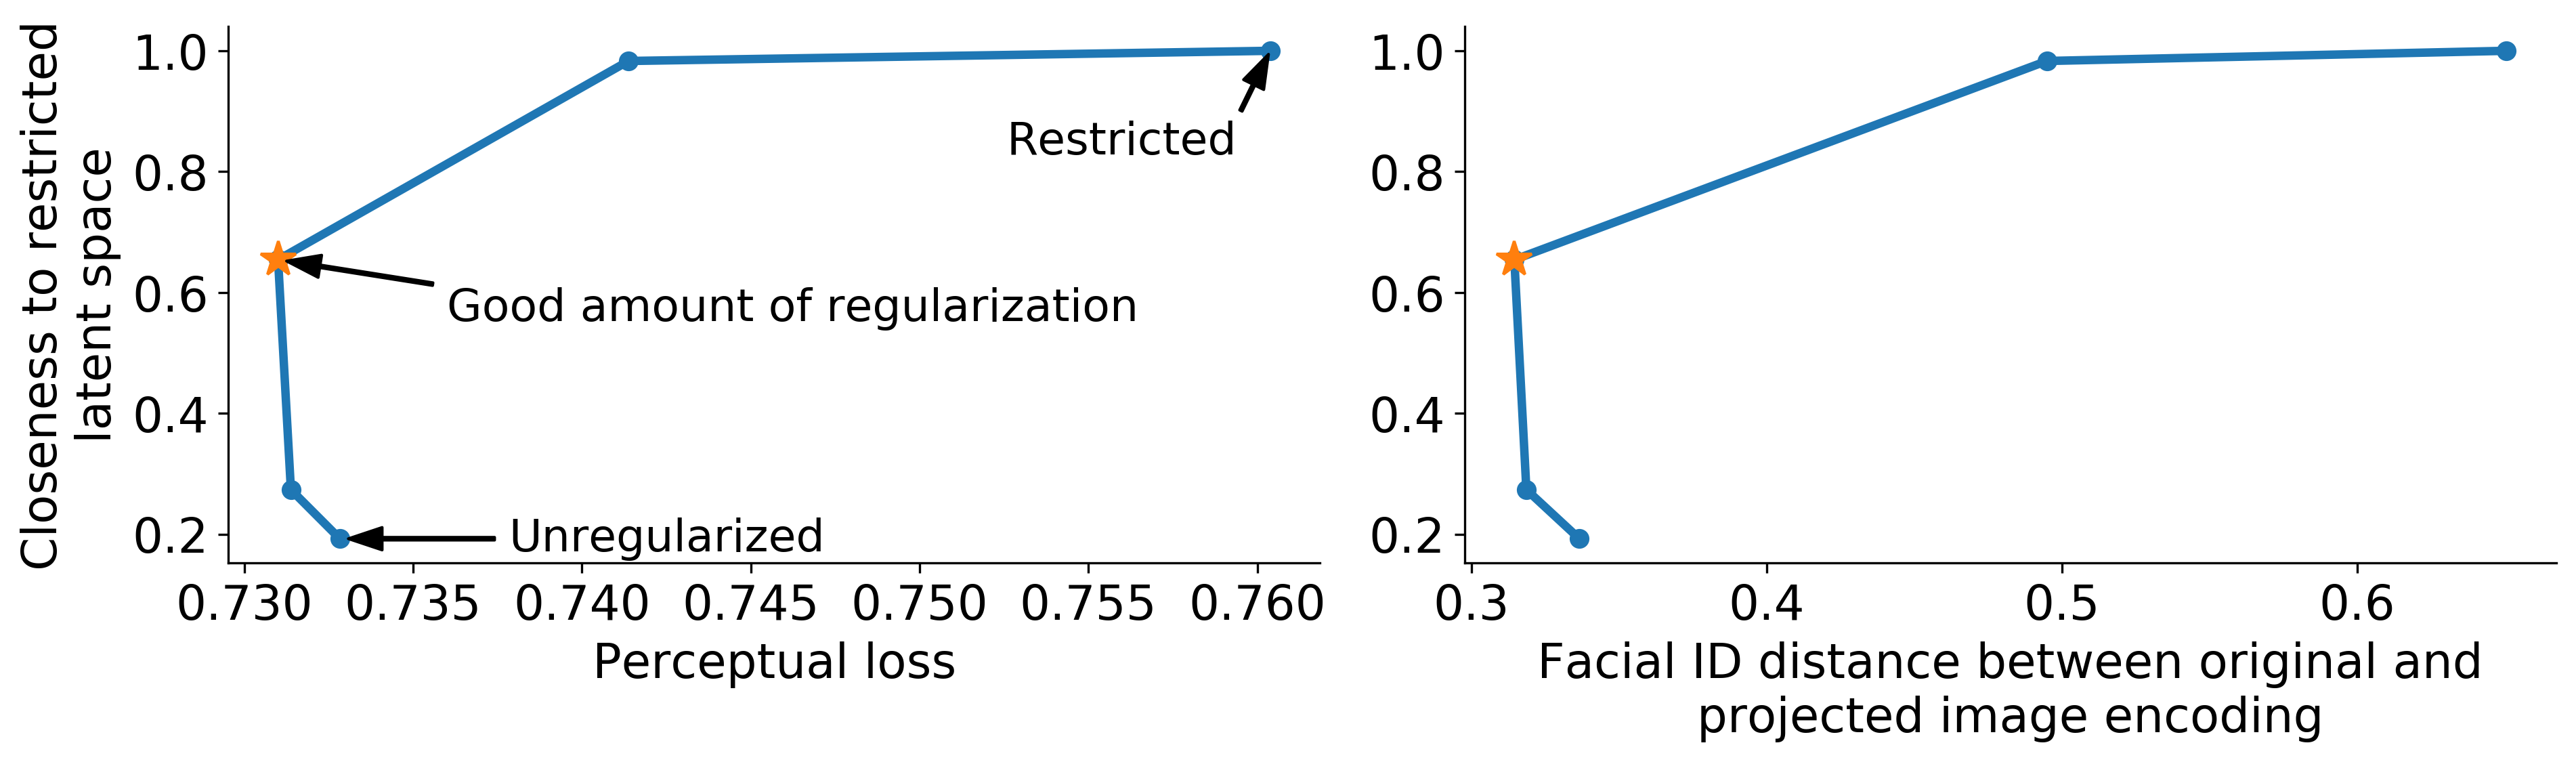

In [48]:
arrow_args = {
    'arrowprops': {
        'facecolor': 'black',
        'width': 1,
        'headwidth': 8,
        'shrink': 0.05
    },
    'xycoords': 'data',
    'textcoords': 'data',
    'horizontalalignment': 'left',
    'verticalalignment': 'center',
}
ykey = 'mean_abs_corr'
plt.figure(dpi=300, figsize=(13, 4))
plt.subplot(121)
means = df.groupby('reg_param').mean().reset_index()
ax = plt.gca()
plt.plot(means['perceptual_loss'], means[ykey], 'o-')

# annotate 0
r0 = means.iloc[0]
(x, y) = r0['perceptual_loss'], r0[ykey]
# plt.text(x0, y0, 'No regularization')
ax.annotate('Unregularized',
            xy=(x, y),
            xytext=(x + 0.005, y), 
            **arrow_args)

# annotate 1
r1 = means.iloc[2]
(x, y) = r1['perceptual_loss'], r1[ykey]
plt.plot(r1['perceptual_loss'], r1[ykey], marker='*', ms=13)
# plt.text(x1, y1, 'Regularization = $10^{-1}$')
ax.annotate('Good amount of regularization', # = $10^{-1}$',
            xy=(x, y),
            xytext=(x + 5e-3, y - 8e-2), 
            **arrow_args)

# annotate 2
r1 = means.iloc[-1]
(x, y) = r1['perceptual_loss'], r1[ykey]
# plt.plot(r1['perceptual_loss'], r1['mean_abs_corr'], marker='*', ms=13)
# plt.text(x, y, 'Unexpanded latent space')
arrow_args['horizontalalignment'] = 'right'
ax.annotate('Restricted',
            xy=(x, y),
            xytext=(x - 1e-3, y - 15e-2), 
            **arrow_args,
           )

plt.ylabel('Closeness to restricted\nlatent space')
plt.xlabel('Perceptual loss')
# util.savefig('projection_perceptual_loss')









# right subplot
plt.subplot(122)
arrow_args = {
    'arrowprops': {
        'facecolor': 'black',
        'width': 1,
        'headwidth': 8,
        'shrink': 0.05
    },
    'xycoords': 'data',
    'textcoords': 'data',
    'horizontalalignment': 'left',
    'verticalalignment': 'center',
}
ykey = 'mean_abs_corr'
plt.plot(d[vals].mean(), means[ykey], 'o-')
plt.plot(d[vals].mean()[2], means[ykey][2], marker='*', ms=13)

plt.xlabel('Facial ID distance between original and\nprojected image encoding')
util.savefig('projection_double')
plt.show()

In [62]:
# d = df
# sns.lmplot('perceptual_loss', 'mean_abs_corr', d, hue='reg_param')
# plt.show()

### face id preservation

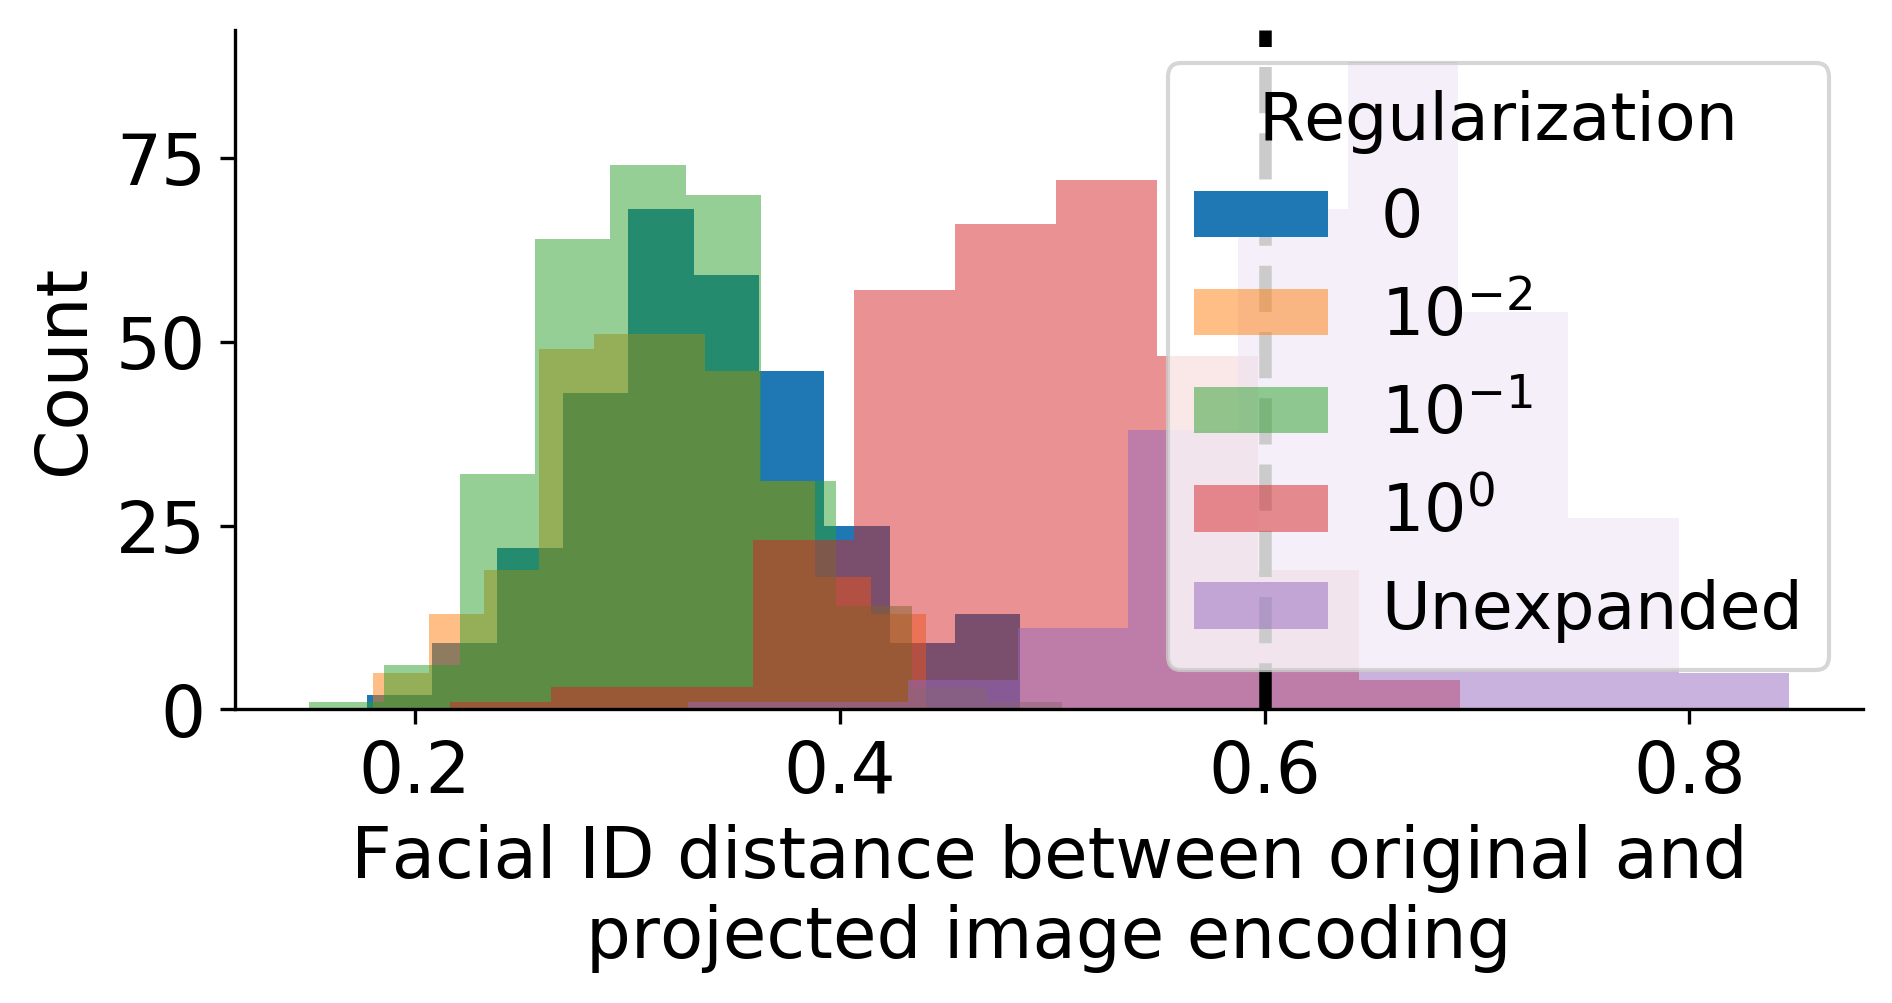

In [69]:
plt.figure(figsize=(7, 3), dpi=300)
plt.hist(d['0.0'], label='0')
plt.hist(d['0.01'], alpha=0.5, label='$10^{-2}$')
plt.hist(d['0.1'], alpha=0.5, label='$10^{-1}$')
plt.hist(d['1.0'], alpha=0.5, label='$10^0$')
plt.hist(d['10000.0'], alpha=0.5, label='Unexpanded')
# plt.yscale('log')
plt.axvline(0.6, linestyle='--', color='black')
plt.legend(title='Regularization')
plt.xlabel('Facial ID distance between original and\nprojected image encoding')
plt.ylabel('Count')
plt.show()

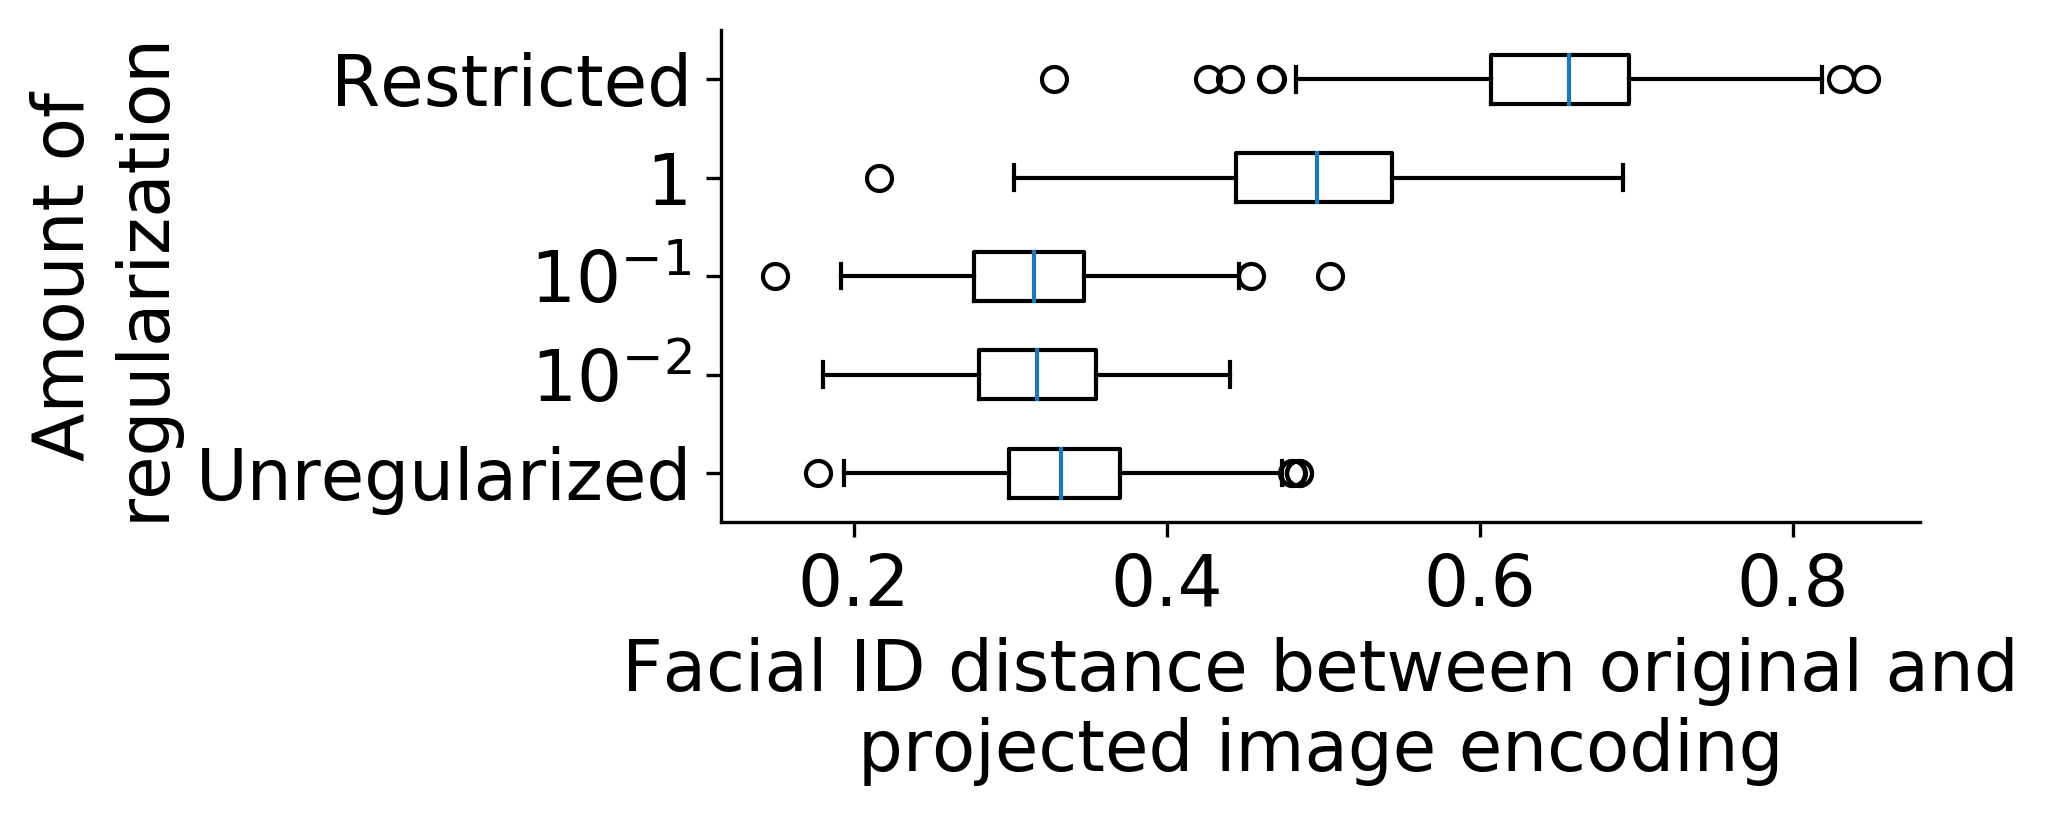

In [16]:
plt.figure(figsize=(7, 3), dpi=300)
vals = ['0.0', '0.01', '0.1', '1.0', '10000.0']
labs = ['Unregularized', '$10^{-2}$', '$10^{-1}$', '1', 'Restricted']
# cs = [style.c0] * 2 + [style.c1] + [style.c0] * 2
plt.boxplot([d[k] for k in vals], vert=False, medianprops={'color': style.c0})
plt.yticks(1 + np.arange(len(vals)), labs)
plt.xlabel('Facial ID distance between original and\nprojected image encoding')
plt.ylabel('Amount of\nregularization')
plt.tight_layout()
util.savefig('projection_facial_dist')

### attr accuracy preservation

In [60]:
print(ks)

['A', 'B', 'C', 'G', 'H', 'M']


In [ ]:
reg_params = df.reg_param.unique()
accs = np.zeros((len(reg_params), len(ks)))
mean_diffs = np.zeros((len(reg_params), len(ks)))
for i, k in enumerate(ks):
    predk = f'pred_{k}'
    # labk = f'lab_{k}'
    labk = f'{config.LABELS[k]}'
    for j, reg_param in enumerate(reg_params):
#     sns.lmplot(predk, labk, df, hue='reg_param')
        d = df[df.reg_param == reg_param]
#         accs[j, i] = np.mean((d[predk] > 0) == (d[labk] > 0))
#         mean_diffs[j, i] = np.mean(d[predk][d[labk] == 1]) - np.mean(d[predk][d[labk] == -1])
        
        accs[j, i] = np.mean((d[predk] > 0) == (d[labk] > 0))
        mean_diffs[j, i] = np.mean(d[predk][d[labk] == 1]) - np.mean(d[predk][d[labk] == 0])

        
def plot_bars(vals, ylab='Accuracy'):
    fig, ax = plt.subplots(dpi=300)
    ind = np.arange(len(ks)) # the x locations for the groups
    ps = []
    if ylab == 'Accuracy':
        plt.axhline(0.5, color='gray', alpha=0.5)
    ax.grid(zorder=0)
    for i in range(len(reg_params)):
        width = 0.14
        val = vals[i, :].flatten()
        ps.append(ax.bar(ind + width * i, val, width, zorder=3))
    plt.xticks(ind + width * 1.5, [config.LABELS[a] for a in ks], fontsize=10)
    
    plt.ylabel(ylab)
    ax.legend(ps, [f'{reg:.0e}' for reg in reg_params])
    plt.show()
    
# plot_bars(mean_diffs, 'Difference in means')
plot_bars(accs, 'Accuracy')